# Tutorial 3: Merging Timeseries With ``merge_dicts``

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/donishadsmith/neurocaps/blob/stable/docs/examples/tutorial-3.ipynb)

``merge_dicts()`` combines timeseries data from different tasks and sessions, enabling analyses
that identify similar CAPs across these tasks, sessions, or both. This is only useful when the tasks and sessions
includes the same subjects. This function produces a merged dictionary only containing subject IDs present across all
input dictionaries. Additionally, while the run IDs across task do not need to be similar, the timeseries of the same
run-IDs across dictionaries will be appended. Note that successful merging requires all dictionaries to contain the
same number of columns/ROIs.

In [1]:
# Download packages
try:
    import neurocaps
except:
    !pip install neurocaps[windows,demo]

In [2]:
import numpy as np
from neurocaps.analysis import merge_dicts

np.random.seed(0)

# Simulate two subject_timeseries dictionaries
# First dictionary contains 3 subjects, each with three runs that have 10 timepoints and 100 rois
subject_timeseries_session_pre = {
    str(x): {f"run-{y}": np.random.rand(10, 100) for y in range(3)} for x in range(3)
}

# Deleting run-2 for subject 2; situation where subject 2 only completed two runs of a task
del subject_timeseries_session_pre["2"]["run-2"]

# Second dictionary contains 2 subjects, each with a single run that have 20 timepoints and 100 rois
subject_timeseries_session_post = {
    str(x): {f"run-{y}": np.random.rand(20, 100) for y in range(1)} for x in range(2)
}

# The subject_timeseries_list also takes pickle files and can save the modified dictionaries as pickles too.
subject_timeseries_merged = merge_dicts(
    subject_timeseries_list=[subject_timeseries_session_pre, subject_timeseries_session_post],
    return_merged_dict=True,
    return_reduced_dicts=False,
)

for subj_id in subject_timeseries_merged["merged"]:
    for run_id in subject_timeseries_merged["merged"][subj_id]:
        timeseries = subject_timeseries_merged["merged"][subj_id][run_id]
        print(f"sub-{subj_id}; {run_id} shape is {timeseries.shape}")

sub-0; run-0 shape is (30, 100)
sub-0; run-1 shape is (10, 100)
sub-0; run-2 shape is (10, 100)
sub-1; run-0 shape is (30, 100)
sub-1; run-1 shape is (10, 100)
sub-1; run-2 shape is (10, 100)


In [3]:
# The original dictionaries can also be returned too. The only modifications done is that the
# originals will only contain the subjects present across all dictionaries in the list. Note that
# the "dict_#" IDs correspond to the index that the subject timeseries are in
# `subject_timeseries_list`.

merged_dicts = merge_dicts(
    subject_timeseries_list=[subject_timeseries_session_pre, subject_timeseries_session_post],
    return_merged_dict=True,
    return_reduced_dicts=True,
)

for dict_id in merged_dicts:
    for subj_id in merged_dicts[dict_id]:
        for run_id in merged_dicts[dict_id][subj_id]:
            timeseries = merged_dicts[dict_id][subj_id][run_id]
            print(f"For {dict_id} sub-{subj_id}; {run_id} shape is {timeseries.shape}")

For dict_0 sub-0; run-0 shape is (10, 100)
For dict_0 sub-0; run-1 shape is (10, 100)
For dict_0 sub-0; run-2 shape is (10, 100)
For dict_0 sub-1; run-0 shape is (10, 100)
For dict_0 sub-1; run-1 shape is (10, 100)
For dict_0 sub-1; run-2 shape is (10, 100)
For dict_1 sub-0; run-0 shape is (20, 100)
For dict_1 sub-1; run-0 shape is (20, 100)
For merged sub-0; run-0 shape is (30, 100)
For merged sub-0; run-1 shape is (10, 100)
For merged sub-0; run-2 shape is (10, 100)
For merged sub-1; run-0 shape is (30, 100)
For merged sub-1; run-1 shape is (10, 100)
For merged sub-1; run-2 shape is (10, 100)


CAPs can be derived using the merged subject timeseries data. This analysis will identify CAPs present across session
or tasks.

2025-07-21 14:30:58,053 neurocaps.analysis.cap._internals.cluster [INFO] No groups specified. Using default group 'All Subjects' containing all subject IDs from `subject_timeseries`. The `groups` dictionary will remain fixed unless the `CAP` class is re-initialized or `clear_groups()` is used.
2025-07-21 14:30:58,175 neurocaps.analysis.cap._internals.cluster [INFO] [GROUP: All Subjects | METHOD: davies_bouldin] Optimal cluster size is 7.


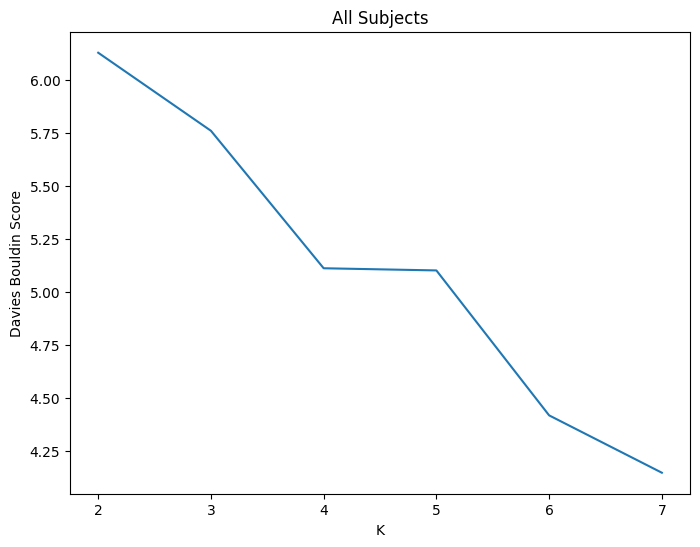

In [4]:
from neurocaps.analysis import CAP

cap_analysis = CAP()

# Deriving CAPs from the merged timeseries data
cap_analysis.get_caps(
    merged_dicts["merged"],
    n_clusters=range(2, 8),
    cluster_selection_method="davies_bouldin",
    show_figs=True,
)

Then each reduced subject timeseries (representing a session or task) can be used to compute the temporal dynamics
of the previously identified CAPs from the merged timeseries. These files can then be used to perform analyses
assessing how to the same CAPs changed across time, tasks, or both time and tasks. Note that if ``standardize`` was set
to True in ``CAP.get_caps()``, then the column (ROI) means and standard deviations computed from the concatenated data
used to obtain the CAPs are also used to standardize each subject in the timeseries data inputted into
``CAP.calculate_metrics()``. This ensures proper CAP assignments for each subjects frames.

In [5]:
cap_analysis.calculate_metrics(
    merged_dicts["dict_0"],
    continuous_runs=False,
    metrics=["persistence"],
    output_dir="neurocaps_demo",
    prefix_filename="session-pre",
)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7
0,0,All Subjects,run-0,0.0,2.0,1.0,1.500000,1.0,1.0,0.0
1,0,All Subjects,run-1,0.0,1.0,0.0,0.000000,1.5,1.0,1.0
2,0,All Subjects,run-2,0.0,0.0,0.0,1.666667,1.5,1.0,1.0
3,1,All Subjects,run-0,0.0,0.0,1.0,2.000000,1.5,2.0,1.0
4,1,All Subjects,run-1,1.0,0.0,1.0,0.000000,3.0,0.0,1.0
5,1,All Subjects,run-2,1.0,1.0,1.0,1.000000,1.0,1.0,0.0


**Note that due to each subject only having a single run, the run names do not change to "run-continuous".**

In [6]:
cap_analysis.calculate_metrics(
    merged_dicts["dict_1"],
    continuous_runs=True,
    metrics=["persistence"],
    output_dir="neurocaps_demo",
    prefix_filename="session-post",
)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4,CAP-5,CAP-6,CAP-7
0,0,All Subjects,run-0,1.0,1.5,0.0,1.0,1.0,1.0,1.166667
1,1,All Subjects,run-0,1.0,1.0,1.0,1.0,1.0,1.8,1.000000
